In [1]:
import gymnasium as gym
import numpy as np
import ipywidgets as widgets
import sys

sys.path.append('../')
import support_modules as sm

# Pendulum

## Description

<div style="text-align: justify">    
The inverted pendulum swingup problem is based on the classic problem in control theory. The system consists of a pendulum attached at one end to a fixed point, and the other end being free. The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.
</div>

https://gymnasium.farama.org/environments/classic_control/pendulum/

# Random policy

## Single episode

In [2]:
env = gym.make('Pendulum-v1', render_mode='human')
state, _ = env.reset()  
done = False

while not done:
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    env.render()
    
    done = sm.evaluate_done(terminated,truncated)

env.close()

## Exploratory 1000 episodes

In [3]:
env = gym.make('Pendulum-v1',render_mode=None)

rewards = list()
success = list()

for episode in range(1000):
    state, _ = env.reset()
    ep_reward = 0
    done = False

    while not done:
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)
    
    rewards.append(ep_reward)
    success.append(terminated)

env.close()
print(f'Success rate: {sum(success)/len(success)}')
print(f'Average reward: {sum(rewards)/len(rewards)}')

Success rate: 0.0
Average reward: -1223.7875316705477


# Q-Learning

### Hyperparameters

In [2]:
# Flexible Parameters (ipywidgets)
EPISODES_W = widgets.IntSlider(value=500000, min=50, max=500000, step=50, description='Number Episodes', 
                               style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})

LEARNING_RATE_W = widgets.FloatSlider(value=0.01, min=0, max=1, step=0.01, description='Learning rate',
                                      style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})
DISCOUNT_W = widgets.FloatSlider(value=0.99, min=0, max=1, step=0.01, description='Discount factor',
                                 style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})

epsilon_W = widgets.FloatSlider(value=1, min=0, max=1, step=0.05, description='Exploration rate',
                                style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})

display(EPISODES_W,LEARNING_RATE_W,DISCOUNT_W,epsilon_W)

START_EPSILON_DECAYING = 1                      # First episode at which decay epsilon

IntSlider(value=500000, description='Number Episodes', layout=Layout(width='40%'), max=500000, min=50, step=50…

FloatSlider(value=0.01, description='Learning rate', layout=Layout(width='40%'), max=1.0, step=0.01, style=Sli…

FloatSlider(value=0.99, description='Discount factor', layout=Layout(width='40%'), max=1.0, step=0.01, style=S…

FloatSlider(value=1.0, description='Exploration rate', layout=Layout(width='40%'), max=1.0, step=0.05, style=S…

## Training

In [3]:
env = gym.make('Pendulum-v1', render_mode=None)

discrete_partitions = 50

# Discrete actions
discrete_actions = [-2,-1.5,-1,-0.75,-0.5,-0.25,-0.1,-0.05,-0.01,0]
discrete_actions.extend([-i for i in discrete_actions[::-1]])
discrete_actions.remove(0)

# Retrieving 
EPISODES = EPISODES_W.value; LEARNING_RATE = LEARNING_RATE_W.value
DISCOUNT = DISCOUNT_W.value; epsilon = epsilon_W.value
epsilon_decaying_value = epsilon / ((EPISODES//1.5) - START_EPSILON_DECAYING)     # Amount of decayment of epsilon    

# Generate the discrete state space and the interval of each discrete space 
discrete_state_space,discrete_state_intervals = sm.Q_Learning_Agent.generate_discrete_states(discrete_partitions,env)

# Generate the q_table 
q_table = sm.Q_Learning_Agent.generate_q_table('random',len(discrete_actions),discrete_state_space,low=-2,high=0)

# Rewards
ep_rewards = list()
success = list()
epsilons = list()


### Training
for episode in range(EPISODES):
    
    episode_reward = 0
    state, info = env.reset()
    discrete_state = sm.Q_Learning_Agent.get_discrete_state(state,env,discrete_state_intervals,discrete_partitions)        # Discrete initial state
    done = False
    
    while not done: 

        if np.random.random() > epsilon:                    # Randomize actions with epsilon
            action = np.argmax(q_table[discrete_state])     # Action taken from the argmax of the current state
        else:
            action = np.random.randint(low=0, high=len(discrete_actions))              # Action taken at random              # Action taken at random
        
        real_action = discrete_actions[action]
        
        new_state, reward, terminated, truncated, info = env.step((real_action,))       # Retrieve information
        done = sm.evaluate_done(terminated,truncated)

        episode_reward += reward
        
        new_discrete_state = sm.Q_Learning_Agent.get_discrete_state(new_state,env,discrete_state_intervals,discrete_partitions)  # Discretize new state
        
        if not done: 
            q_table = sm.Q_Learning_Agent.update_q_table(q_table,discrete_state,new_discrete_state,action,reward,LEARNING_RATE,DISCOUNT)
        
        discrete_state = new_discrete_state                 # Update state
    
    epsilon = sm.Q_Learning_Agent.linear_epsilon_decay(epsilon,episode,epsilon_decaying_value,START_EPSILON_DECAYING,EPISODES//1.5)
    
    ep_rewards.append(episode_reward)
    success.append(terminated)
    epsilons.append(epsilon)
     
env.close()

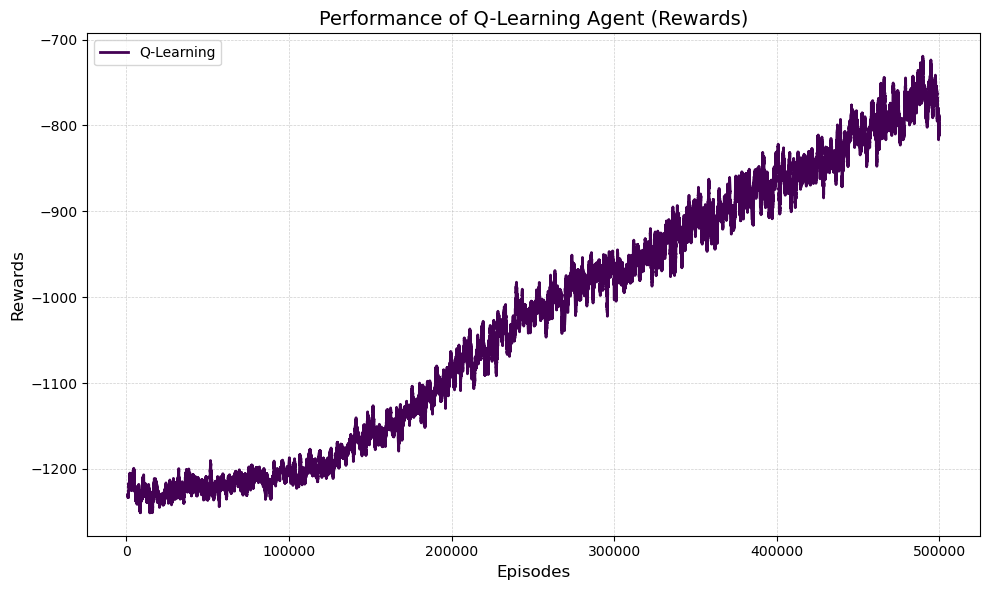

In [4]:
# Visualizing training results
sm.visualizations.plot_moving_average([ep_rewards],['Q-Learning'],1000,
                                      title='Performance of Q-Learning Agent (Rewards)',ylabel='Rewards')

## Testing

### Visualizing Trained Agent

In [6]:
env = gym.make('Pendulum-v1', render_mode='human')
state, _ = env.reset()
discrete_state = sm.Q_Learning_Agent.get_discrete_state(state,env,discrete_state_intervals,discrete_partitions)
done = False

while not done:
    action = np.argmax(q_table[discrete_state])
    state, reward, terminated, truncated, info = env.step((discrete_actions[action],))
    discrete_state = sm.Q_Learning_Agent.get_discrete_state(state,env,discrete_state_intervals,discrete_partitions)
    env.render()
    
    done = sm.evaluate_done(terminated,truncated)

env.close()

### Testing Agent on 100 New Episodes

In [8]:
env = gym.make('Pendulum-v1', render_mode=None)
testing_rewards = list()

for episode in range(100):
    state, _ = env.reset()
    discrete_state = sm.Q_Learning_Agent.get_discrete_state(state,env,discrete_state_intervals,discrete_partitions)
    done = False
    ep_reward = 0

    while not done:
        action = np.argmax(q_table[discrete_state])
        state, reward, terminated, truncated, info = env.step((discrete_actions[action],))
        discrete_state = sm.Q_Learning_Agent.get_discrete_state(state,env,discrete_state_intervals,discrete_partitions)

        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)

    testing_rewards.append(ep_reward)
env.close()

print(f'Average rewards of Q-Learning Agent on 100 episodes: {round(sum(testing_rewards)/len(testing_rewards),2)}')

Average rewards of Q-Learning Agent on 100 episodes: -848.77


# Stables Baselines 3

## A2C

In [20]:
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env

# Parallel environments
vec_env = make_vec_env("Pendulum-v1", n_envs=4)

A2C_model = A2C("MlpPolicy", vec_env, verbose=0)
A2C_model.learn(total_timesteps=100_000)

env = gym.make('Pendulum-v1', render_mode=None)
testing_success = list()
testing_rewards = list()

for episode in range(100):
    state, _ = env.reset()
    done = False
    ep_reward = 0

    while not done:
        action, _state = A2C_model.predict(state, deterministic=True)
        state, reward, terminated, truncated, info = env.step(action)

        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)

    testing_rewards.append(ep_reward)
env.close()

print(f'Average rewards of (trained) A2C Agent on 100 episodes: {round(sum(testing_rewards)/len(testing_rewards),2)}')

Average rewards of (trained) A2C Agent on 100 episodes: -1369.6


## DDPG

In [22]:
from stable_baselines3 import DDPG
from stable_baselines3.common.env_util import make_vec_env

# Parallel environments
# vec_env = make_vec_env("Pendulum-v1", n_envs=4)
env = gym.make('Pendulum-v1', render_mode=None)

# DDPG_model = DDPG("MlpPolicy", vec_env, verbose=0)
DDPG_model = DDPG("MlpPolicy", env, verbose=0)
DDPG_model.learn(total_timesteps=100_000)

env = gym.make('Pendulum-v1', render_mode=None)
testing_success = list()
testing_rewards = list()

for episode in range(100):
    state, _ = env.reset()
    done = False
    ep_reward = 0

    while not done:
        action, _state = DDPG_model.predict(state, deterministic=True)
        state, reward, terminated, truncated, info = env.step(action)

        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)

    testing_rewards.append(ep_reward)
env.close()

print(f'Average rewards of (trained) DDPG Agent on 100 episodes: {round(sum(testing_rewards)/len(testing_rewards),2)}')

Average rewards of (trained) DDPG Agent on 100 episodes: -155.23


## PPO

In [17]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Parallel environments
vec_env = make_vec_env("Pendulum-v1", n_envs=4)

PPO_model = PPO("MlpPolicy", vec_env, verbose=0)
PPO_model.learn(total_timesteps=100_000)

env = gym.make('Pendulum-v1', render_mode=None)
testing_success = list()
testing_rewards = list()

for episode in range(100):
    state, _ = env.reset()
    done = False
    ep_reward = 0

    while not done:
        action, _state = PPO_model.predict(state, deterministic=True)
        state, reward, terminated, truncated, info = env.step(action)

        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)

    testing_rewards.append(ep_reward)
env.close()

print(f'Average rewards of (trained) PPO Agent on 100 episodes: {round(sum(testing_rewards)/len(testing_rewards),2)}')

Average rewards of (trained) PPO Agent on 100 episodes: -1064.88


## SAC

In [23]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env

# Parallel environments
vec_env = make_vec_env("Pendulum-v1", n_envs=4)

SAC_model = SAC("MlpPolicy", vec_env, verbose=0)
SAC_model.learn(total_timesteps=100_000)

env = gym.make('Pendulum-v1', render_mode=None)
testing_success = list()
testing_rewards = list()

for episode in range(100):
    state, _ = env.reset()
    done = False
    ep_reward = 0

    while not done:
        action, _state = SAC_model.predict(state, deterministic=True)
        state, reward, terminated, truncated, info = env.step(action)

        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)

    testing_rewards.append(ep_reward)
env.close()

print(f'Average rewards of (trained) SAC Agent on 100 episodes: {round(sum(testing_rewards)/len(testing_rewards),2)}')

Average rewards of (trained) SAC Agent on 100 episodes: -136.62


## Visualize Trained Stable Baselines Models

In [25]:
model = SAC_model

env = gym.make('Pendulum-v1', render_mode='human')
state, _ = env.reset()
done = False

while not done:
    action, _state = model.predict(state, deterministic=True)
    state, reward, terminated, truncated, info = env.step(action)
    env.render()
    
    done = sm.evaluate_done(terminated,truncated)

env.close()